In [146]:
import json
import pandas as pd
import numpy as np
import re  # For regular expressions.
import matplotlib.pyplot as plt
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [147]:
raw_data = pd.read_json("all_scripts_raw.json")
#raw_data.head()

I am only interested in The Original Series from 1966 at the moment.

In [148]:
episodes_raw = raw_data['TOS'].keys()
series_lines_raw = raw_data['TOS']

In [149]:
#episodes_raw

In [150]:
#series_lines_raw

This data has to be cleaned, as there is a lot of noise here. 
Ideally we want to get the lines in the following format: 

ONE CHARACTER: Line of dialogue.

ANOTHERCHARACTER: A different line of dialogue from a different person

I want it to look like every line has the name of the character in all caps, a colon, and the spoken words. Each line is separated by a newline.

In [151]:
pd.DataFrame(series_lines_raw).shape

(176, 1)

In [152]:
#Function to clean the text in each episode

def clean_episode(episode_text):
    if isinstance(episode_text, str): #To check if to check if episode_text is a string before applying the regular expressions.
        # Remove text at the start of each episode
        cleaned = re.sub("(The Star Trek Transcripts(.|\n)*?)([A-Z' ]+:+)", r"\3", episode_text)

        # Remove text at the end of the episode
        cleaned = re.sub("<Back(.|\n)*", "", cleaned)

        # Remove cases of " [OC]" – this is when a character is speaking off-camera. Generally background noise or just a throw-away coment to set the scene
        cleaned = cleaned.replace(" [OC]", "")

        # Remove scene descriptions, which are surrounded by [] and () parentheses. We only want the lines from characters.
        cleaned = re.sub(" ?[\(\[](.|\n)*?[\)\]]", "", cleaned)

        # Remove non-breaking space characters
        cleaned = cleaned.replace('\u00a0', '');

        # Remove multiple instances of '\n'.
        cleaned = cleaned.replace('\n \n', '\n');
        cleaned = re.sub("(\n)+", "\n", cleaned)
        
        # Remove multiple instances of ':'.
        cleaned = cleaned.replace('::', ':');

        # Remove lines starting with "Captain's log", etc. Though this is normally Kirk, sometimes they can be by other characters and the script doesn't specify who it is.
        # It might still be possible to ascertain who speaks these by inferring from the content but that will be more complex. 
        # For simplicity we only stick to lines of dialogue with interacting characters, that move the plot forward.
         
        cleaned = re.sub("((Captain's [Ll]og|Ship's [Ll]og|First [Oo]fficer's [Ll]og|Enterprise [Ll]og)(.|\n)*?)([A-Z' ]+:)", r"\4", cleaned)

        # Remove newlines that are in the middle of a spoken line
        cleaned = re.sub("(?<! )\n(?!([A-Z' ]*?:))", " ", cleaned)
        
        # Remove leading and trailing spaces as well as newlines
        cleaned = cleaned.strip()

        # # Remove additional occurrences of special characters
        # cleaned = cleaned.replace('\r', '').replace('\r\n', '').replace('\n', '')

        # # Insert space before certain characters to prevent word merging
        # cleaned = re.sub(r'(?<=[a-zA-Z])([.:;?!])(?=[a-zA-Z])', r' \1', cleaned)

        # # Insert space before a character's name if it directly follows the end of a sentence
        # cleaned = re.sub(r'(?<=[a-z])(?=[A-Z])', ' ', cleaned)


        return cleaned
    
    else:
        return episode_text  # Return as is if it's not a string

In [153]:
# Clean all episodes
series_lines_clean = []
for i,ep in enumerate(episodes_raw):
    series_lines_clean.append(clean_episode(series_lines_raw[i]))

In [154]:
pd.DataFrame(series_lines_clean).shape 

(176, 1)

A quick comparison between the original and cleaned, for the 1st episode:

As can be seen in the comparison, the cleaned lines have all the noise removed.

In [155]:
# A function that takes one episode_text as input. 
# Format such that every line is the name of the character in all caps, a colon, and the line, with each line starting on a newline.
# Extract a dictionary with key as character name and value being an array of lines from the character.

def group_by_character(episode_text):
    if isinstance(episode_text, str):
        lines_by_character = {} #Dictionary to store the lines by each character
        # Each spoken line is separated by a newline so we create a list of all the split lines
        split_lines = episode_text.split('\n') 

        for line in split_lines:
            # Looking for the name of the character (all caps but can have an apostrophe, or a space, followed by a colon)
            name = re.search("([A-Z' ]+)(?=:+)", line)
            # Getting the actual spoken words after the colon 
            words = re.search("(?<=:)(.*)", line)
            if name is not None:
                name = name.group(0).strip() # removes leading and trailing spaces from the name 
                words = words.group(0).strip() #removes leading and trailing spaces from the   spoken words.
                if name in lines_by_character.keys():
                    lines_by_character[name].append(words) #Add to the characters lines in the dictionary 
                else:
                    lines_by_character[name]=[words] #Add a new character to the dictionary if it is a new one
        return lines_by_character
    else:
        return {}  # Return an empty dictionary if it's not a string

Now go through every episode to do the above function to get the lines and words by character.

In [156]:
# Group the lines by character for every episode
series_lines_by_character = []
for i,ep in enumerate(episodes_raw):
    series_lines_by_character.append(group_by_character(series_lines_clean[i]))

In [157]:
test = pd.DataFrame(series_lines_by_character)
test.shape

(176, 438)

Let's try to group lines by character so we can analyse each character's sentiment. 
The first dataset grouped lines by episode and then by character. 
Let's replicae this grouping so that we can use the functions created.

In [158]:
#Function to compute the total word counts and line counts for each character across multiple episodes
# Takes input of dictionaries:
# series_lines (lines spoken by each character in each episode)
# episode_list (names or indices of the episodes)
# use_episode_name_as_index – a boolean indicating whether the episode name should be used as an index for counting 

def word_line_counts(series_lines, episode_list, use_episode_name_as_index):
    total_word_counts={} # Dictionary to store the total word counts for each character across all episodes.
    total_line_counts={} # Dictionary to store the line counts for each character across all episodes.
    for i,ep in enumerate(episode_list):
        # Different datasets require different index types
        if use_episode_name_as_index:
            index = ep
        else:
            index = i
        if series_lines[index] is not np.NaN:
            for member in list(series_lines[index].keys()): 
                total_words_by_member_in_ep = sum([len(line.split()) for line in series_lines[index][member]]) #  summing the number of words in each spoken line for that character
                total_lines_by_member_in_ep = len(series_lines[index][member]) #  number of lines spoken by that character.
                if member in total_word_counts.keys(): #  character already exists in the dictionaries
                    total_word_counts[member]=total_word_counts[member]+total_words_by_member_in_ep 
                    total_line_counts[member]=total_line_counts[member]+total_lines_by_member_in_ep
                else: # character doesn't exist yet in dictionary - initialise the count for that character
                    total_word_counts[member]=total_words_by_member_in_ep
                    total_line_counts[member]=total_lines_by_member_in_ep
    return total_word_counts, total_line_counts

In [159]:
clean_word_counts, clean_line_counts = word_line_counts(series_lines_by_character, episodes_raw, False)

In [160]:
#clean_word_counts

In [161]:
#clean_line_counts

In [162]:

def graph_word_line_counts(word_counts, line_counts):
    # Place the figures side-by-side
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    
    # Changes the colors of the bars
    bar_cmap = plt.get_cmap("Set2")

    # Plot number of words
    words_df=pd.DataFrame(list(word_counts.items()), columns=['Character','No. of Words'])
    most_words=words_df.sort_values(by='No. of Words', ascending=False).head(25)
    most_words.plot.bar(x='Character',y='No. of Words', ax=ax1, color=bar_cmap.colors)

    # Plot number of lines
    lines_df=pd.DataFrame(list(line_counts.items()), columns=['Character','No. of Lines'])
    most_lines=lines_df.sort_values(by='No. of Lines', ascending=False).head(25)
    most_lines.plot.bar(x='Character',y='No. of Lines', ax=ax2, color=bar_cmap.colors)
    plt.show()

Cleaned graphs


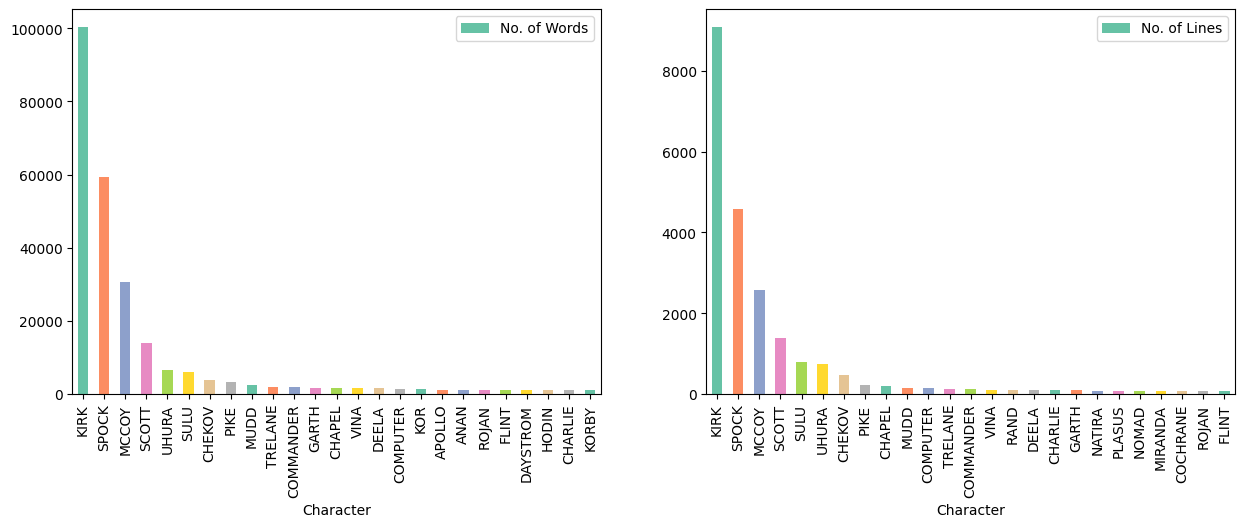

In [163]:
print("Cleaned graphs")
graph_word_line_counts(clean_word_counts, clean_line_counts)

In [164]:
import plotly.graph_objs as go


In [165]:
def plot_word_line_counts(clean_word_counts, clean_line_counts):
    # Convert lists to DataFrame
    words_df = pd.DataFrame(list(clean_word_counts.items()), columns=['Character', 'No. of Words'])
    lines_df = pd.DataFrame(list(clean_line_counts.items()), columns=['Character', 'No. of Lines'])
    
    # Sort DataFrame by counts
    most_words = words_df.sort_values(by='No. of Words', ascending=False).head(25)
    most_lines = lines_df.sort_values(by='No. of Lines', ascending=False).head(25)
    
    # Specify a color for the bars
    bar_color = 'skyblue'
    
    # Create Plotly figures for word counts and line counts
    fig1 = go.Figure(go.Bar(x=most_words['Character'], y=most_words['No. of Words'], marker_color=bar_color))
    fig1.update_layout(title='Number of Words by Character', xaxis_title='Character', yaxis_title='Number of Words')

    fig2 = go.Figure(go.Bar(x=most_lines['Character'], y=most_lines['No. of Lines'], marker_color=bar_color))
    fig2.update_layout(title='Number of Lines by Character', xaxis_title='Character', yaxis_title='Number of Lines')
    
    fig1.show() 
    fig2.show()

In [166]:
plot_word_line_counts(clean_word_counts, clean_line_counts)


In [167]:
import nltk

In [43]:
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [168]:
# Initialize sentiment analyzer
sia = SentimentIntensityAnalyzer()

In [169]:
characters_of_interest = ['SPOCK', 'KIRK', 'MCCOY']

# Create dictionaries to store sentiment scores for each character and episode
sentiment_scores = {char: {'episode': [], 'overall': []} for char in characters_of_interest}


In [170]:
char_lines = pd.DataFrame(series_lines_by_character)
char_lines.head()

,SPOCK,TYLER,ONE,PIKE,GARISON,BOYCE,COLT,GEOLOGIST,PITCAIRN,OLD MAN,...,ATOZ,WENCH,LAW,ZARABETH,JUDGE,JAILOR,COLEMAN,JANICE,LYSA,LEMLI
0,"[Check the circuit., It can't be the screen th...","[All operating, sir., It could be these meteor...","[No, it's something else. There's still someth...","[Steady as we go., They were keyed to cause in...","[It's a radio wave, sir. We're passing through...","[I understand we picked up a distress signal.,...","[Yes, sir., But you wanted the reports by oh f...","[Geological lab report complete, Captain., Our...","[Yes, sir. There's a canyon to the left. We ca...",[They're men. They're humans.],...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"[Miss Uhura, your last sub-space log contained...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,[That is a very intriguing question. Scanners ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"[Your move, Captain., I'll have you checkmated...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"[Check out the life-support systems., Someone ...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [171]:
three_char = char_lines[characters_of_interest]
char_episodes = three_char.dropna(how='all')
char_episodes

,SPOCK,KIRK,MCCOY
0,"[Check the circuit., It can't be the screen th...",NaN,NaN
1,"[Miss Uhura, your last sub-space log contained...","[Shall we pick some flowers, Doctor? When a ma...","[Is that how you get girls to like you, by bri..."
2,[That is a very intriguing question. Scanners ...,"[All right, Chief, begin materialisation.\r Ca...",[Tell me. The ship's supply of food\r concentr...
3,"[Your move, Captain., I'll have you checkmated...",[We should have intercepted by now. The Bridge...,NaN
4,"[Check out the life-support systems., Someone ...","[Kirk, affirmative., What caused it?, Captain ...","[You're fine, Joe. Up and out of there.\r Mist..."
...,...,...,...
75,"[It is definitely the stolen space cruiser, Ca...","[Hailing frequencies. Aurora, this is the USS ...",[Trouble. Your friend here didn't want a check...
76,"[It is, Captain., They've already been provide...","[At Federation orders, we're\r proceeding at t...","[That may not be easy, Jim. Medical analysis i..."
77,[I still read a suggestion of carbon cycle lif...,"[Spock, any answers?, Which is scientifically ...",[What's all this poppycock about life forms on...
78,[The power source we detected is in this build...,"[Any sign of survivors?, If they knew that the...",[How can a planet full of people just disappea...


The first episode does not have any lines from Kirk because interestingly, he only appeared from Episode 2 onwards. It was Pike who was captain in the pilot.

In [172]:
spock_lines = char_episodes['SPOCK']

In [173]:
spock_lines

0     [Check the circuit., It can't be the screen th...
1     [Miss Uhura, your last sub-space log contained...
2     [That is a very intriguing question. Scanners ...
3     [Your move, Captain., I'll have you checkmated...
4     [Check out the life-support systems., Someone ...
                            ...                        
75    [It is definitely the stolen space cruiser, Ca...
76    [It is, Captain., They've already been provide...
77    [I still read a suggestion of carbon cycle lif...
78    [The power source we detected is in this build...
79    [Captain. Tricorder picking up very faint life...
Name: SPOCK, Length: 80, dtype: object

In [175]:
# Iterate through the characters of interest
for char in characters_of_interest:
    # Extract the lines spoken by the character and store them in a Series
    character_lines = char_episodes[char].fillna("").astype(str)  # Ensure lines are treated as strings
    
    # Perform sentiment analysis on the character's lines
    sentiment_scores[char]['episode'] = character_lines.apply(lambda x: sia.polarity_scores(x)['compound'])
    
    # Calculate overall sentiment score for the character across all episodes
    sentiment_scores[char]['overall'] = sentiment_scores[char]['episode'].mean()

# Convert sentiment_scores to a DataFrame for easy analysis and visualization
sentiment_df = pd.DataFrame(sentiment_scores)

sentiment_df

,SPOCK,KIRK,MCCOY
episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
overall,-0.005304,0.224218,0.104833


In [176]:
sentiment_scores['SPOCK']

{'episode': 0    -0.6641
 1    -0.9900
 2    -0.9457
 3    -0.8881
 4     0.9743
        ...  
 75   -0.9693
 76   -0.9787
 77    0.9643
 78   -0.8361
 79    0.9326
 Name: SPOCK, Length: 80, dtype: float64,
 'overall': -0.005303749999999992}

In [177]:
spock_sent = pd.DataFrame(sentiment_scores['SPOCK'])

In [178]:
spock_sent

,episode,overall
0,-0.6641,-0.005304
1,-0.9900,-0.005304
2,-0.9457,-0.005304
3,-0.8881,-0.005304
4,0.9743,-0.005304
...,...,...
75,-0.9693,-0.005304
76,-0.9787,-0.005304
77,0.9643,-0.005304
78,-0.8361,-0.005304


In [179]:
spock_sent = spock_sent.drop(['overall'], axis=1)
#spock_sent.reset_index(inplace=True)

spock_sent


,episode
0,-0.6641
1,-0.9900
2,-0.9457
3,-0.8881
4,0.9743
...,...
75,-0.9693
76,-0.9787
77,0.9643
78,-0.8361


In [180]:
spock_sent.columns = ['Spock']

In [181]:
spock_sent

,Spock
0,-0.6641
1,-0.9900
2,-0.9457
3,-0.8881
4,0.9743
...,...
75,-0.9693
76,-0.9787
77,0.9643
78,-0.8361


In [182]:
kirk_sent = pd.DataFrame(sentiment_scores['KIRK'])
kirk_sent = kirk_sent.drop(['overall'], axis=1)
kirk_sent.columns = ['KIRK']
kirk_sent

,KIRK
0,0.0000
1,0.9957
2,0.9965
3,0.9917
4,0.9606
...,...
75,0.9934
76,0.9939
77,0.9758
78,0.7055


In [183]:
mccoy_sent = pd.DataFrame(sentiment_scores['MCCOY'])
mccoy_sent = mccoy_sent.drop(['overall'], axis=1)
mccoy_sent.columns = ['MCCOY']
mccoy_sent

,MCCOY
0,0.0000
1,0.7874
2,0.9415
3,0.0000
4,-0.4213
...,...
75,0.7456
76,0.3504
77,0.8351
78,-0.9790


In [184]:
result_df = pd.concat([spock_sent, kirk_sent, mccoy_sent], axis=1)

# Rename the columns if needed
result_df.columns = ['Spock', 'Kirk', 'McCoy']

# Display the resulting DataFrame
result_df

,Spock,Kirk,McCoy
0,-0.6641,0.0000,0.0000
1,-0.9900,0.9957,0.7874
2,-0.9457,0.9965,0.9415
3,-0.8881,0.9917,0.0000
4,0.9743,0.9606,-0.4213
...,...,...,...
75,-0.9693,0.9934,0.7456
76,-0.9787,0.9939,0.3504
77,0.9643,0.9758,0.8351
78,-0.8361,0.7055,-0.9790


In [185]:
# Create traces for each character
traces = []
for column in result_df.columns:
    trace = go.Scatter(x=result_df.index, y=result_df[column], mode='lines', name=column)
    traces.append(trace)

# Create the figure
fig = go.Figure(data=traces)

# Add buttons to show/hide each character's line
buttons = []
for column in result_df.columns:
    button = dict(label=column,
                  method="update",
                  args=[{"visible": [True if col == column else False for col in result_df.columns]},
                        {"title": f"Sentiment Scores - {column}"}])
    buttons.append(button)

# Add a button to show all lines
buttons.append(dict(label="Show All",
                    method="update",
                    args=[{"visible": [True] * len(result_df.columns)},
                          {"title": "Sentiment Scores - All Characters"}]))

# Add buttons to the layout
fig.update_layout(updatemenus=[dict(buttons=buttons, direction="down", showactive=True)])

# Set layout options
fig.update_layout(title="Sentiment Scores - All Characters", xaxis_title="Episode", yaxis_title="Sentiment Score")

# Show the plot
fig.show()

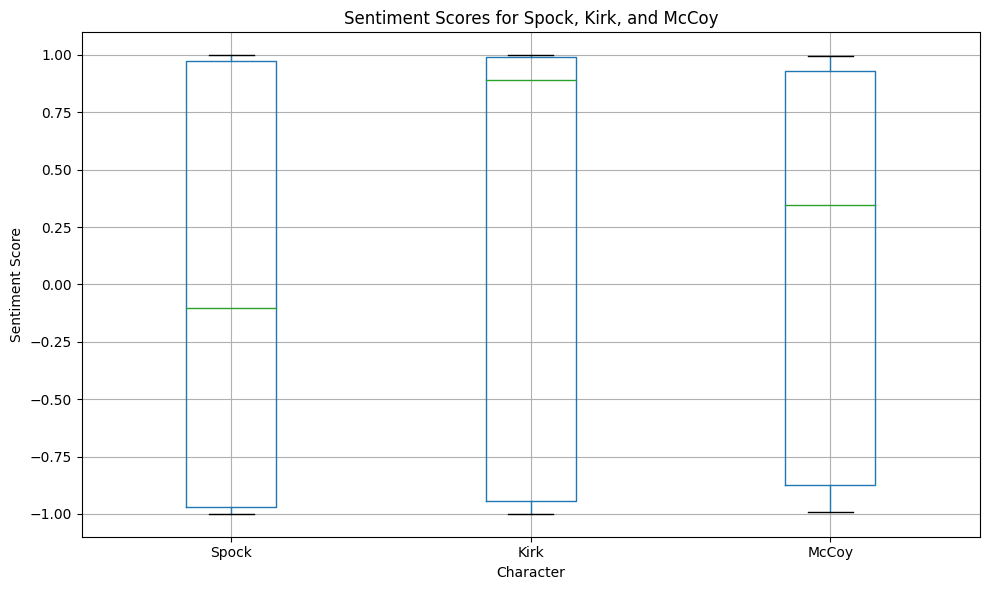

In [63]:
# Plot a box plot
result_df.boxplot(figsize=(10, 6))
plt.xlabel('Character')
plt.ylabel('Sentiment Score')
plt.title('Sentiment Scores for Spock, Kirk, and McCoy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [186]:
#series_lines_clean

In [66]:
series_for_sent = pd.DataFrame(series_lines_clean)


,0
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
171,NaN
172,NaN
173,NaN
174,NaN


In [67]:
series_for_sent = series_for_sent.dropna()
series_for_sent

,0
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
75,SPOCK: It is definitely the stolen space cruis...
76,"KIRK: At Federation orders, we're\r proceeding..."
77,"SULU: All observation stations, take final\r r..."
78,SPOCK: The power source we detected is in this...


In [69]:
series_for_sent.columns = ['episode']

In [70]:
series_for_sent

,episode
0,SPOCK: Check the circuit. \r\nTYLER: All opera...
1,"KIRK: Shall we pick some flowers, Doctor? When..."
2,"KIRK: All right, Chief, begin materialisation...."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should..."
4,SPOCK: Check out the life-support systems. \r\...
...,...
75,SPOCK: It is definitely the stolen space cruis...
76,"KIRK: At Federation orders, we're\r proceeding..."
77,"SULU: All observation stations, take final\r r..."
78,SPOCK: The power source we detected is in this...


In [64]:
def calculate_sentiment(line):
    return sia.polarity_scores(line)['compound']


/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_33548/2058395039.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  series_for_sent['cumulative_sentiment'] = series_for_sent['episode'].apply(lambda x: [calculate_sentiment(line) for line in x.split('\n') if line.strip()])
/var/folders/r5/v547ncv97r9_mbyn2hvcwjz40000gp/T/ipykernel_33548/2058395039.py:14: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


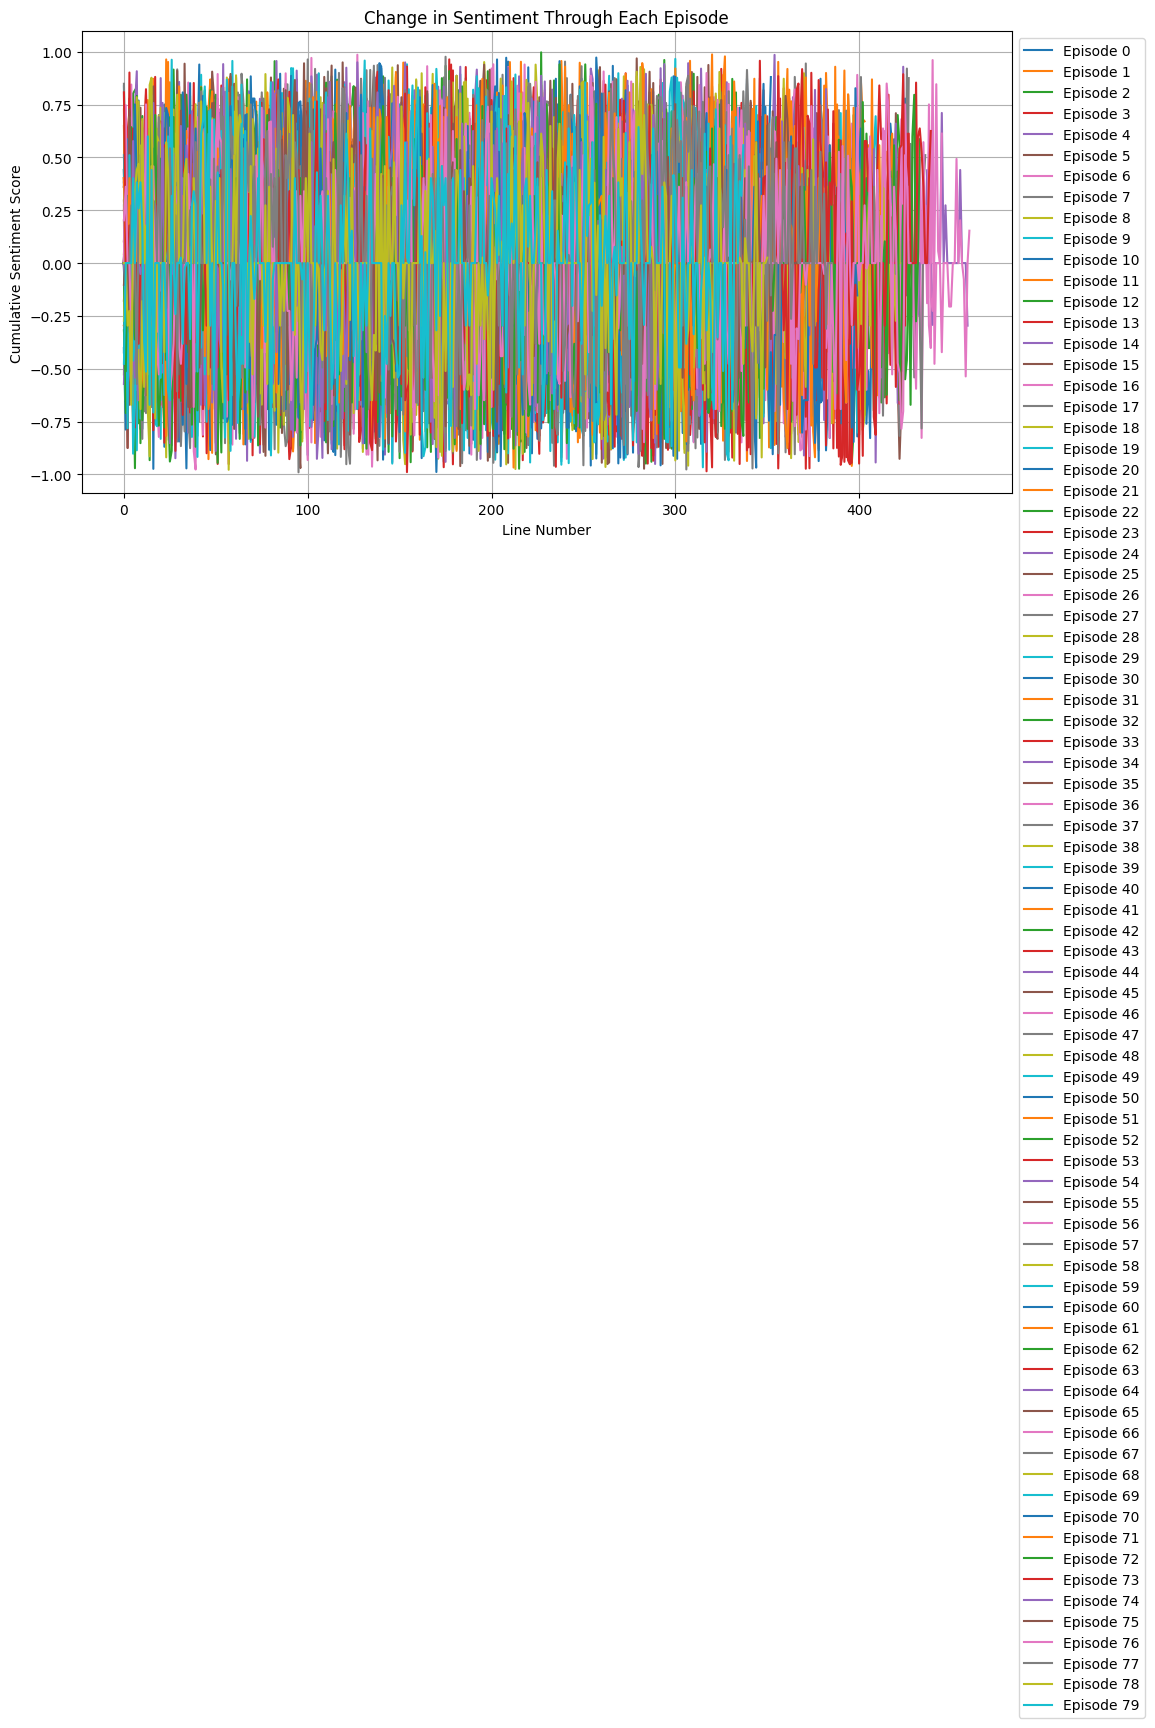

In [71]:
# Apply sentiment analysis to each row (episode) and accumulate the sentiment scores
series_for_sent['cumulative_sentiment'] = series_for_sent['episode'].apply(lambda x: [calculate_sentiment(line) for line in x.split('\n') if line.strip()])

# Plot the change in sentiment through each episode
plt.figure(figsize=(12, 6))
for idx, row in series_for_sent.iterrows():
    plt.plot(row['cumulative_sentiment'], label=f'Episode {idx}')

plt.xlabel('Line Number')
plt.ylabel('Cumulative Sentiment Score')
plt.title('Change in Sentiment Through Each Episode')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout()
plt.show()

In [72]:
series_for_sent

,episode,cumulative_sentiment
0,SPOCK: Check the circuit. \r\nTYLER: All opera...,"[0.0, 0.0, 0.4019, 0.0, -0.296, -0.3612, 0.0, ..."
1,"KIRK: Shall we pick some flowers, Doctor? When...","[0.3612, 0.3612, 0.0, -0.4696, 0.4215, 0.0, 0...."
2,"KIRK: All right, Chief, begin materialisation....","[0.0, 0.0, 0.0, 0.0, 0.0, 0.802, 0.8176, 0.831..."
3,"SPOCK: Your move, Captain. \r\nKIRK: We should...","[0.0, 0.0, 0.0, -0.2247, -0.0772, 0.5862, 0.0,..."
4,SPOCK: Check out the life-support systems. \r\...,"[0.0, 0.0, -0.5423, -0.6486, 0.0, -0.033, 0.0,..."
...,...,...
75,SPOCK: It is definitely the stolen space cruis...,"[-0.1027, 0.0, 0.0, -0.296, -0.4215, 0.0, 0.0,..."
76,"KIRK: At Federation orders, we're\r proceeding...","[0.2023, 0.3612, 0.0, 0.0, -0.34, 0.0, 0.0, 0...."
77,"SULU: All observation stations, take final\r r...","[0.0, 0.0, 0.0, 0.0, 0.2732, 0.0, 0.0, -0.5719..."
78,SPOCK: The power source we detected is in this...,"[0.0, 0.0, -0.296, -0.2263, -0.6705, 0.25, 0.3..."


In [74]:
series_for_sent[1][1]

KeyError: 1

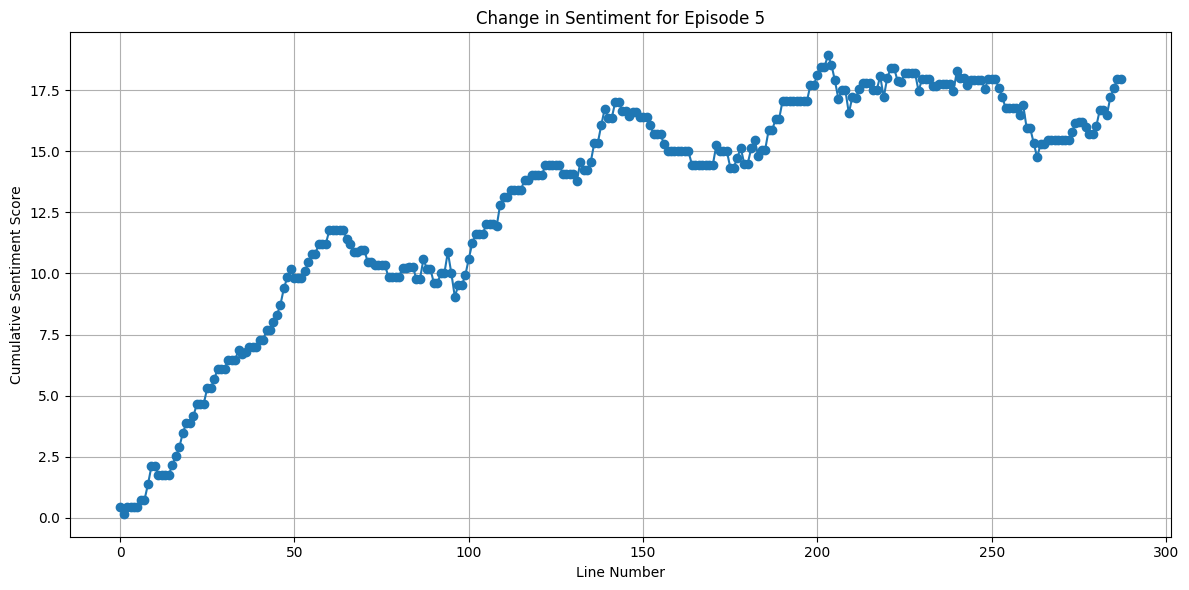

In [75]:
# Select the specific episode you want to analyze (e.g., Episode 5)
episode_to_analyze = 5
selected_episode = series_for_sent.loc[episode_to_analyze, 'episode']

# Apply sentiment analysis and accumulate the sentiment scores for the selected episode
cumulative_sentiment = []
for line in selected_episode.split('\n'):
    line = line.strip()
    if line:
        sentiment_score = calculate_sentiment(line)
        if cumulative_sentiment:
            sentiment_score += cumulative_sentiment[-1]
        cumulative_sentiment.append(sentiment_score)

# Plot the change in sentiment for the selected episode
plt.figure(figsize=(12, 6))
plt.plot(cumulative_sentiment, marker='o')

plt.xlabel('Line Number')
plt.ylabel('Cumulative Sentiment Score')
plt.title(f'Change in Sentiment for Episode {episode_to_analyze}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [79]:
import matplotlib
matplotlib.use('TkAgg')  # Use 'TkAgg' or another appropriate backend

from matplotlib.animation import FuncAnimation


In [86]:
# Create a figure and axis for the animation
fig, ax = plt.subplots(figsize=(10, 6))

# Function to update the plot for each episode
def update(frame):
    ax.clear()
    episode = series_for_sent.loc[frame, 'episode']
    cumulative_sentiment = []
    for line in episode.split('\n'):
        line = line.strip()
        if line:
            sentiment_score = calculate_sentiment(line)
            if cumulative_sentiment:
                sentiment_score += cumulative_sentiment[-1]
            cumulative_sentiment.append(sentiment_score)
    ax.plot(cumulative_sentiment, marker='o')
    ax.set_xlabel('Line Number')
    ax.set_ylabel('Cumulative Sentiment Score')
    ax.set_title(f'Change in Sentiment for Episode {frame}')
    ax.grid(True)

# Define the range of episodes to display (e.g., the first 5 episodes)
episode_range = range(5)

# Create the animation
animation = FuncAnimation(fig, update, frames=episode_range, repeat=False)

plt.show()

In [83]:
animation.save('sentiment_animation.mp4', writer='ffmpeg')

MovieWriter ffmpeg unavailable; using Pillow instead.


ValueError: unknown file extension: .mp4

In [ ]:
sentiment_scores

In [35]:
df = pd.DataFrame(sentiment_scores)
df.reset_index(inplace=True)

# Rename the columns for clarity
df.columns = ['episode', 'Spock', 'Kirk', 'McCoy']
df

,episode,Spock,Kirk,McCoy
0,episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
1,overall,-0.005304,0.224218,0.104833


In [28]:
sentiment_df

,SPOCK,KIRK,MCCOY
episode,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...,0 0.0000 1 0.9957 2 0.9965 3 0...,0 0.0000 1 0.7874 2 0.9415 3 0...
overall,-0.005304,0.224218,0.104833


In [29]:
sentiment_df_reset = sentiment_df.reset_index()

# Use the 'melt' function to reshape the DataFrame
melted_sentiment_df = pd.melt(sentiment_df_reset, id_vars='index', var_name='character', value_name='sentiment_score')

# Rename the columns for clarity
melted_sentiment_df.columns = ['episode', 'character', 'sentiment_score']

# Display the reformatted DataFrame
melted_sentiment_df

,episode,character,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,overall,SPOCK,-0.005304
2,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
3,overall,KIRK,0.224218
4,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
5,overall,MCCOY,0.104833


In [31]:
# Reset the index to make 'character' a regular column
sentiment_df_reset = sentiment_df.reset_index()

# Use the 'stack' function to unstack the DataFrame
unstacked_sentiment_df = sentiment_df_reset.set_index('index').stack().reset_index()

# Rename the columns for clarity
unstacked_sentiment_df.columns = ['character', 'episode', 'sentiment_score']

# Display the reformatted DataFrame
unstacked_sentiment_df

,character,episode,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
2,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
3,overall,SPOCK,-0.005304
4,overall,KIRK,0.224218
5,overall,MCCOY,0.104833


In [33]:
# Create a new DataFrame where each row represents an episode
episode_sentiment_df = sentiment_df.copy()
episode_sentiment_df.reset_index(inplace=True)

# Melt the DataFrame to have sentiment scores for each episode in separate rows
melted_episode_sentiment_df = episode_sentiment_df.melt(id_vars='index', var_name='character', value_name='sentiment_score')
melted_episode_sentiment_df.columns = ['episode', 'character', 'sentiment_score']

# Display the reformatted DataFrame
melted_episode_sentiment_df

,episode,character,sentiment_score
0,episode,SPOCK,0 -0.6641 1 -0.9900 2 -0.9457 3 -0...
1,overall,SPOCK,-0.005304
2,episode,KIRK,0 0.0000 1 0.9957 2 0.9965 3 0...
3,overall,KIRK,0.224218
4,episode,MCCOY,0 0.0000 1 0.7874 2 0.9415 3 0...
5,overall,MCCOY,0.104833


In [20]:
# Iterate through episodes and lines grouped by character
for episode_lines_by_character in asdf:
    # Iterate through the characters of interest (Spock, Kirk, McCoy)
    for char in characters_of_interest:
        # Check if the character is in the lines for the current episode
        if char in episode_lines_by_character:
            # Get the lines spoken by the character (already combined into a single string)
            character_lines = episode_lines_by_character[char]
            
            # Perform sentiment analysis on the character's lines
            sentiment = sia.polarity_scores(character_lines)
            
            # Append sentiment scores for the current episode
            sentiment_scores[char]['episode'].append(sentiment['compound'])


AttributeError: 'list' object has no attribute 'encode'

In [10]:
for episode in data[:5]:  # Print the first 5 episodes as an example
    print(episode)

TypeError: unhashable type: 'slice'

In [8]:
# Process each line of dialogue
for episode in data:
    for line in episode['lines']:
        character = line['character']
        text = line['text']
        sentiment = sia.polarity_scores(text)
        
        if character == 'Spock':
            spock_sentiment['episode'].append(sentiment['compound'])
        elif character == 'Kirk':
            kirk_sentiment['episode'].append(sentiment['compound'])
        elif character == 'Bones':
            bones_sentiment['episode'].append(sentiment['compound'])

TypeError: string indices must be integers, not 'str'